In [1]:
%cd E:\COLLEGE MATERIAL\Ordinal_Shading

E:\COLLEGE MATERIAL\Ordinal_Shading


In [2]:
import sys
sys.path.insert(0, "imports")

In [3]:

import os
import glob
from tqdm import tqdm
import numpy as np
import torch

# Ensure local imports work
import sys
sys.path.insert(0, "imports")

from chrislib.general import view, invert
from chrislib.data_util import load_image
from intrinsic.pipeline import run_pipeline
from altered_midas.midas_net import MidasNet
from altered_midas.midas_net_custom import MidasNet_small

In [4]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# MANUAL MODEL LOADING (local weights)
# -----------------------------
print("📦 Loading models manually from local weights...")
model_dir = "models"
ord_model = MidasNet()
ord_model.load_state_dict(torch.load(os.path.join(model_dir, "stage_0_v21.pt"), map_location=device))
ord_model.eval()
ord_model = ord_model.to(device)

iid_model = MidasNet_small(exportable=False, input_channels=5, output_channels=1)
iid_model.load_state_dict(torch.load(os.path.join(model_dir, "stage_1_v21.pt"), map_location=device))
iid_model.eval()
iid_model = iid_model.to(device)

col_model = MidasNet(activation='sigmoid', input_channels=7, output_channels=2)
col_model.load_state_dict(torch.load(os.path.join(model_dir, "stage_2_v21.pt"), map_location=device))
col_model.eval()
col_model = col_model.to(device)

alb_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3, last_residual=True)
alb_model.load_state_dict(torch.load(os.path.join(model_dir, "stage_3_v21.pt"), map_location=device))
alb_model.eval()
alb_model = alb_model.to(device)

dif_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3)
dif_model.load_state_dict(torch.load(os.path.join(model_dir, "stage_4_v21.pt"), map_location=device))
dif_model.eval()
dif_model = dif_model.to(device)

models = {
    "ord_model": ord_model,
    "iid_model": iid_model,
    "col_model": col_model,
    "alb_model": alb_model,
    "dif_model": dif_model,
}
print("✅ Models loaded")

📦 Loading models manually from local weights...


Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main


✅ Models loaded


In [ ]:
# -----------------------------
# CONFIG
# -----------------------------
# Path to your ARAP dataset input images
input_dir = "E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images"

# Output directories for predicted intrinsic components
output_root = "E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Output_Images"
alb_dir = os.path.join(output_root, "albedo")
shd_dir = os.path.join(output_root, "shading")
os.makedirs(alb_dir, exist_ok=True)
os.makedirs(shd_dir, exist_ok=True)



# -----------------------------
# GET LIST OF INPUT IMAGES
# -----------------------------
image_paths = sorted(glob.glob(os.path.join(input_dir, "*.png")) +
                     glob.glob(os.path.join(input_dir, "*.jpg")) +
                     glob.glob(os.path.join(input_dir, "*.jpeg")))

print(f"Found {len(image_paths)} images in {input_dir}")

# -----------------------------
# PROCESS IMAGES
# -----------------------------
for img_path in tqdm(image_paths, desc="Processing images"):
    # Load image
    image = load_image(img_path)
    # Ensure image is RGB (3 channels)
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]

    # Run pipeline
    results = run_pipeline(models, image, device=device)

    # Get outputs
    alb = view(results["hr_alb"])         # gamma-corrected albedo
    shd = 1 - invert(results["dif_shd"])  # tonemapped diffuse shading

    # File name without extension
    fname = os.path.splitext(os.path.basename(img_path))[0]

    # Save albedo and shading separately
    alb_save = (alb * 255).astype(np.uint8)
    shd_save = (shd * 255).astype(np.uint8)

    from imageio import imwrite
    imwrite(os.path.join(alb_dir, f"{fname}_alb.png"), alb_save)
    imwrite(os.path.join(shd_dir, f"{fname}_shd.png"), shd_save)

print(f"🎉 Done! Outputs saved in:\n  Albedo → {alb_dir}\n  Shading → {shd_dir}")


Found 21 images in E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images


Processing images:  10%|▉         | 2/21 [00:26<03:56, 12.44s/it]

In [4]:
import os
import time
import re
import numpy as np
from imageio import imwrite

# IIW Dataset paths
iiw_input_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images"
iiw_output_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\output"
os.makedirs(iiw_output_dir, exist_ok=True)

# --- Prevent accidental concurrent double-run (which duplicates output lines) ---
if globals().get('_IIW_PROCESSING_ACTIVE', False):
    raise RuntimeError("IIW processing already running in this kernel. Wait for it to finish or restart kernel.")
_IIW_PROCESSING_ACTIVE = True

# --- Ensure dependencies from previous cell are available after a restart ---
import sys
sys.path.insert(0, "imports")
try:
    load_image
except NameError:
    from chrislib.data_util import load_image  # Will raise if unavailable
try:
    view
except NameError:
    from chrislib.general import view, invert
try:
    run_pipeline
except NameError:
    from intrinsic.pipeline import run_pipeline
if 'models' not in globals():
    _IIW_PROCESSING_ACTIVE = False
    raise RuntimeError("'models' dict missing. Execute the model loading cell above.")
if 'device' not in globals():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"

def numeric_sort_key(path):
    """Return (leading_number, lowercase_name) for consistent numeric ordering."""
    fname = os.path.splitext(os.path.basename(path))[0]
    m = re.match(r'^(\d+)', fname)
    if m:
        return (int(m.group(1)), fname.lower())
    return (float('inf'), fname.lower())

# Collect images once (case-insensitive filtering) using os.listdir to avoid duplicate glob matches
image_files = []
for f in os.listdir(iiw_input_dir):
    fl = f.lower()
    if fl.endswith(('.png', '.jpg', '.jpeg')):
        image_files.append(os.path.join(iiw_input_dir, f))

# Sort and take only the first N images
iiw_image_paths = sorted(image_files, key=numeric_sort_key)
MAX_TO_PROCESS = 1000
batch_paths = iiw_image_paths[:MAX_TO_PROCESS]

print(f"Found {len(iiw_image_paths)} images in {iiw_input_dir}")
print(f"Processing first {len(batch_paths)} images in numeric order")
if batch_paths:
    preview = [os.path.splitext(os.path.basename(p))[0] for p in batch_paths[:15]]
    print("Numeric processing order preview (first 15):", preview)

total_images = len(batch_paths)
start_time = time.time()
for idx, img_path in enumerate(batch_paths, 1):
    iter_start = time.time()
    image = load_image(img_path)
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]
    results = run_pipeline(models, image, device=device)
    alb = view(results["hr_alb"])
    alb_save = (alb * 255).astype(np.uint8)
    fname = os.path.splitext(os.path.basename(img_path))[0]
    out_path = os.path.join(iiw_output_dir, f"{fname}_reflectance.png")
    imwrite(out_path, alb_save)
    iter_time = time.time() - iter_start
    remaining = (total_images - idx) * iter_time
    eta = time.strftime('%H:%M:%S', time.gmtime(max(0, remaining)))
    print(f"Image {idx}/{total_images} ({fname}) | Time/iter: {iter_time:.2f}s | ETA: {eta}")

print(f"🎉 IIW reflectance outputs saved in: {iiw_output_dir}")
_IIW_PROCESSING_ACTIVE = False

Found 5230 images in E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images
Processing first 1000 images in numeric order
Numeric processing order preview (first 15): ['54', '63', '116', '119', '141', '176', '180', '182', '227', '239', '245', '253', '257', '262', '277']
Image 1/1000 (54) | Time/iter: 6.78s | ETA: 01:52:52
Image 1/1000 (54) | Time/iter: 6.78s | ETA: 01:52:52
Image 2/1000 (63) | Time/iter: 6.25s | ETA: 01:43:55
Image 2/1000 (63) | Time/iter: 6.25s | ETA: 01:43:55
Image 3/1000 (116) | Time/iter: 6.48s | ETA: 01:47:42
Image 3/1000 (116) | Time/iter: 6.48s | ETA: 01:47:42
Image 4/1000 (119) | Time/iter: 5.69s | ETA: 01:34:29
Image 4/1000 (119) | Time/iter: 5.69s | ETA: 01:34:29
Image 5/1000 (141) | Time/iter: 6.34s | ETA: 01:45:12
Image 5/1000 (141) | Time/iter: 6.34s | ETA: 01:45:12
Image 6/1000 (176) | Time/iter: 6.33s | ETA: 01:44:50
Image 6/1000 (176) | Time/iter: 6.33s | ETA: 01:44:50
Image 7/1000 (180) | Time/iter: 6.34s | ETA: 01:44:53
Image 7/1000 (180) | Time/

In [5]:
# -----------------------------
# CONFIG
# -----------------------------
# Path to your Synthetic Dense dataset input images
input_dir = "E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input"

# Output directories for predicted intrinsic components
output_root = "E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_output"
alb_dir = os.path.join(output_root, "albedo")
shd_dir = os.path.join(output_root, "shading")
os.makedirs(alb_dir, exist_ok=True)
os.makedirs(shd_dir, exist_ok=True)

# -----------------------------
# GET LIST OF INPUT IMAGES
# -----------------------------
image_paths = sorted(glob.glob(os.path.join(input_dir, "*.png")) +
                     glob.glob(os.path.join(input_dir, "*.jpg")) +
                     glob.glob(os.path.join(input_dir, "*.jpeg")))

print(f"Found {len(image_paths)} images in {input_dir}")

# -----------------------------
# PROCESS IMAGES
# -----------------------------
for img_path in tqdm(image_paths, desc="Processing images"):
    # Load image
    image = load_image(img_path)
    # Ensure image is RGB (3 channels)
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]

    # Run pipeline
    results = run_pipeline(models, image, device=device)

    # Get outputs
    alb = view(results["hr_alb"])         # gamma-corrected albedo
    shd = 1 - invert(results["dif_shd"])  # tonemapped diffuse shading

    # File name without extension
    fname = os.path.splitext(os.path.basename(img_path))[0]

    # Save albedo and shading separately
    alb_save = (alb * 255).astype(np.uint8)
    shd_save = (shd * 255).astype(np.uint8)

    from imageio import imwrite
    imwrite(os.path.join(alb_dir, f"{fname}_alb.png"), alb_save)
    imwrite(os.path.join(shd_dir, f"{fname}_shd.png"), shd_save)

print(f"🎉 Done! Outputs saved in:\n  Albedo → {alb_dir}\n  Shading → {shd_dir}")


Found 23 images in E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input


Processing images: 100%|██████████| 23/23 [03:10<00:00,  8.29s/it]

🎉 Done! Outputs saved in:
  Albedo → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_output\albedo
  Shading → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_output\shading


In [7]:
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from imageio import imread
from skimage.transform import resize

# ARAP paths (use raw strings to avoid escape issues)
arap_pred_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Output_Images\albedo"
arap_pred_shading_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Output_Images\shading"
arap_gt_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo"
arap_gt_shading_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading"

def to_gray_strict(arr):
    # Drop alpha if present, then convert to grayscale and squeeze to 2D
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a, b):
    # Ensure odd window <= min(h, w); fallback to 3 if needed
    h, w = b.shape
    win = min(7, h, w)
    if win < 3:
        win = 3
    if win % 2 == 0:
        win -= 1
    return ssim(a, b, data_range=1.0, win_size=win)

def compute_metrics(pred_dir, gt_dir, metric_type):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    for fname in pred_files:
        low = fname.lower()
        if metric_type == 'alb' and (low.endswith('_alb.png') or low.endswith('_alb.jpg') or low.endswith('_alb.jpeg')):
            base_name = fname.rsplit('_alb', 1)[0]
            gt_suffix = '_albedo'
        elif metric_type == 'shd' and (low.endswith('_shd.png') or low.endswith('_shd.jpg') or low.endswith('_shd.jpeg')):
            base_name = fname.rsplit('_shd', 1)[0]
            gt_suffix = '_shading'
        else:
            print(f"Skipping {fname} (unexpected suffix)")
            continue
        gt_file = None
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
            candidate = f"{base_name}{gt_suffix}{ext}"
            if os.path.exists(os.path.join(gt_dir, candidate)):
                gt_file = candidate
                break
        if gt_file is None:
            print(f"No GT found for {fname}")
            continue
        pred_img = imread(os.path.join(pred_dir, fname)).astype(np.float32) / 255.0
        gt_img = imread(os.path.join(gt_dir, gt_file)).astype(np.float32) / 255.0
        # Grayscale first, strictly 2D
        pred_gray = to_gray_strict(pred_img)
        gt_gray = to_gray_strict(gt_img)
        # Resize only grayscale to match shapes
        if pred_gray.shape != gt_gray.shape:
            pred_gray = resize(pred_gray, gt_gray.shape, order=1, preserve_range=True, anti_aliasing=True)
        # LMSE implementation on grayscale
        def lmse(gt, pred, window_size=20, window_shift=10):
            h, w = gt.shape
            if h < window_size or w < window_size:
                # If image too small for one window, fallback to global MSE
                return float(np.mean((gt - pred) ** 2))
            errors = []
            for i in range(0, h - window_size + 1, window_shift):
                for j in range(0, w - window_size + 1, window_shift):
                    gt_patch = gt[i:i+window_size, j:j+window_size]
                    pred_patch = pred[i:i+window_size, j:j+window_size]
                    mse = np.mean((gt_patch - pred_patch) ** 2)
                    errors.append(mse)
            return float(np.mean(errors)) if errors else float('nan')
        lmse_val = lmse(gt_gray, pred_gray, window_size=20, window_shift=10)
        rmse_val = float(np.sqrt(np.mean((pred_gray - gt_gray) ** 2)))
        ssim_val = float(safe_ssim(pred_gray, gt_gray))
        lmse_vals.append(lmse_val)
        rmse_vals.append(rmse_val)
        ssim_vals.append(ssim_val)
    return float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals))

# Compute metrics for albedo
lmse_alb, rmse_alb, ssim_alb = compute_metrics(arap_pred_albedo_dir, arap_gt_albedo_dir, metric_type='alb')
print(f"ARAP Albedo: LMSE={lmse_alb:.4f}, RMSE={rmse_alb:.4f}, SSIM={ssim_alb:.4f}")

# Compute metrics for shading
lmse_shd, rmse_shd, ssim_shd = compute_metrics(arap_pred_shading_dir, arap_gt_shading_dir, metric_type='shd')
print(f"ARAP Shading: LMSE={lmse_shd:.4f}, RMSE={rmse_shd:.4f}, SSIM={ssim_shd:.4f}")

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_22708\1334083212.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_img = imread(os.path.join(pred_dir, fname)).astype(np.float32) / 255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_22708\1334083212.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_img = imread(os.path.join(gt_dir, gt_file)).astype(np.float32) / 255.0


ARAP Albedo: LMSE=0.0746, RMSE=0.2347, SSIM=0.6942
ARAP Shading: LMSE=0.1073, RMSE=0.2859, SSIM=0.5479
ARAP Shading: LMSE=0.1073, RMSE=0.2859, SSIM=0.5479


In [8]:
# Compute WHDR for IIW outputs using attached whdr logic (Python 3 safe)
import os, json, sys
sys.path.insert(0, "imports")
import numpy as np
from PIL import Image

# Paths (raw strings for Windows)
iiW_output_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\output"
iiW_annotations_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\annotations"

# --- WHDR utilities (ported to Py3, in-notebook) ---
def srgb_to_rgb(srgb):
    srgb = np.asarray(srgb, dtype=np.float32)
    ret = np.zeros_like(srgb, dtype=np.float32)
    idx0 = srgb <= 0.04045
    idx1 = ~idx0
    ret[idx0] = srgb[idx0] / 12.92
    ret[idx1] = np.power((srgb[idx1] + 0.055) / 1.055, 2.4)
    return ret

def load_image_linear(filename, is_srgb=True):
    if not filename:
        raise ValueError("Empty filename")
    image = np.asarray(Image.open(filename)).astype(np.float32) / 255.0
    if is_srgb:
        return srgb_to_rgb(image)
    else:
        return image

def compute_whdr(reflectance, judgements, delta=0.10):
    points = judgements['intrinsic_points']
    comparisons = judgements['intrinsic_comparisons']
    id_to_points = {p['id']: p for p in points}
    rows, cols = reflectance.shape[0:2]

    error_sum = 0.0
    weight_sum = 0.0

    for c in comparisons:
        darker = c.get('darker')
        if darker not in ('1', '2', 'E'):
            continue

        weight = c.get('darker_score')
        if weight is None or weight <= 0:
            continue

        p1 = id_to_points.get(c['point1'])
        p2 = id_to_points.get(c['point2'])
        if p1 is None or p2 is None:
            continue
        if not p1.get('opaque', False) or not p2.get('opaque', False):
            continue

        y1 = min(rows - 1, max(0, int(p1['y'] * rows)))
        x1 = min(cols - 1, max(0, int(p1['x'] * cols)))
        y2 = min(rows - 1, max(0, int(p2['y'] * rows)))
        x2 = min(cols - 1, max(0, int(p2['x'] * cols)))

        l1 = max(1e-10, float(np.mean(reflectance[y1, x1, ...])))
        l2 = max(1e-10, float(np.mean(reflectance[y2, x2, ...])))

        if l2 / l1 > 1.0 + delta:
            alg_darker = '1'
        elif l1 / l2 > 1.0 + delta:
            alg_darker = '2'
        else:
            alg_darker = 'E'

        if darker != alg_darker:
            error_sum += weight
        weight_sum += weight

    if weight_sum > 0:
        return error_sum / weight_sum
    return None

# --- Batch evaluation over available outputs ---
# We only evaluate files present in the output directory; we expect names like 1014_reflectance.png
valid_exts = ('.png', '.jpg', '.jpeg')
reflectance_files = [f for f in os.listdir(iiW_output_dir) if f.lower().endswith(valid_exts) and '_reflectance' in f]
reflectance_files.sort()

results = []
for f in reflectance_files:
    stem = os.path.splitext(f)[0]
    # Expect pattern <photoid>_reflectance
    if not stem.endswith('_reflectance'):
        continue
    photo_id = stem.rsplit('_reflectance', 1)[0]
    json_path = os.path.join(iiW_annotations_dir, f"{photo_id}.json")
    img_path = os.path.join(iiW_output_dir, f)
    if not os.path.exists(json_path):
        print(f"Skipping {f}: missing annotations {photo_id}.json")
        continue
    try:
        refl = load_image_linear(img_path, is_srgb=True)  # saved PNGs are sRGB; convert to linear
        with open(json_path, 'r') as jf:
            judg = json.load(jf)
        score = compute_whdr(refl, judg, delta=0.10)
        if score is None:
            print(f"{photo_id}: no valid judgements; WHDR=None")
            continue
        results.append((photo_id, score))
        print(f"{photo_id}: WHDR={score:.4f}")
    except Exception as e:
        print(f"{photo_id}: error computing WHDR -> {e}")

if results:
    mean_whdr = float(np.mean([s for _, s in results]))
    print(f"\nEvaluated {len(results)} images. Mean WHDR = {mean_whdr:.4f}")
else:
    print("No WHDR scores computed. Ensure output images and matching JSONs exist.")

10013: WHDR=0.0664
10066: WHDR=0.1251
10068: WHDR=0.2598
10070: WHDR=0.2439
10121: WHDR=0.2971
10068: WHDR=0.2598
10070: WHDR=0.2439
10121: WHDR=0.2971
10143: WHDR=0.3850
10148: WHDR=0.0901
1014: WHDR=0.6847
10143: WHDR=0.3850
10148: WHDR=0.0901
1014: WHDR=0.6847
10152: WHDR=0.0431
10165: WHDR=0.0539
10152: WHDR=0.0431
10165: WHDR=0.0539
10174: WHDR=0.2074
10224: WHDR=0.2471
10231: WHDR=0.1331
10174: WHDR=0.2074
10224: WHDR=0.2471
10231: WHDR=0.1331
10272: WHDR=0.5949
10291: WHDR=0.5542
10272: WHDR=0.5949
10291: WHDR=0.5542
10324: WHDR=0.0914
10331: WHDR=0.0848
10324: WHDR=0.0914
10331: WHDR=0.0848
10348: WHDR=0.2501
10356: WHDR=0.3703
10348: WHDR=0.2501
10356: WHDR=0.3703
10361: WHDR=0.3711
10386: WHDR=0.2474
10361: WHDR=0.3711
10386: WHDR=0.2474
10403: WHDR=0.4733
10403: WHDR=0.4733
10436: WHDR=0.3030
10456: WHDR=0.3173
10436: WHDR=0.3030
10456: WHDR=0.3173
10457: WHDR=0.3697
10466: WHDR=0.3641
10457: WHDR=0.3697
10466: WHDR=0.3641
10469: WHDR=0.3046
10477: WHDR=0.5146
10483: WHDR=0.

In [6]:
# Synthetic Dense Albedo Metrics Only (LMSE, RMSE, SSIM) with robust GT matching
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from imageio import imread
from skimage.transform import resize

# Synthetic Dense paths (update if your dataset root differs)
sd_pred_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_output\albedo"
sd_gt_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Gt_albedo"

def to_gray_strict(arr):
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a, b):
    h, w = b.shape
    win = min(7, h, w)
    if win < 3: win = 3
    if win % 2 == 0: win -= 1
    return ssim(a, b, data_range=1.0, win_size=win)

def find_gt_file(gt_dir: str, stem: str):
    candidates = []
    # Common direct patterns
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
        candidates.append(f"{stem}_albedo{ext}")
        candidates.append(f"{stem}{ext}")
    for c in candidates:
        p = os.path.join(gt_dir, c)
        if os.path.exists(p):
            return p
    # Fallback: scan directory for files that start with stem and contain 'alb' or 'albedo'
    low_stem = stem.lower()
    for f in os.listdir(gt_dir):
        fl = f.lower()
        if (fl.startswith(low_stem)) and (('albedo' in fl) or ('alb' in fl)) and fl.endswith(tuple(['.png','.jpg','.jpeg','.PNG','.JPG','.JPEG'])):
            return os.path.join(gt_dir, f)
    return None

def compute_albedo_metrics(pred_dir, gt_dir):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not pred_files:
        print(f"⚠ No predicted albedo files found in {pred_dir}")
        return None, None, None
    matched = 0; missing = 0
    for fname in pred_files:
        low = fname.lower()
        if not (low.endswith('_alb.png') or low.endswith('_alb.jpg') or low.endswith('_alb.jpeg')):
            continue
        stem = fname.rsplit('_alb', 1)[0]
        gt_path = find_gt_file(gt_dir, stem)
        if gt_path is None:
            missing += 1
            continue
        pred_path = os.path.join(pred_dir, fname)
        pred_img = imread(pred_path).astype(np.float32) / 255.0
        gt_img = imread(gt_path).astype(np.float32) / 255.0
        pred_gray = to_gray_strict(pred_img)
        gt_gray = to_gray_strict(gt_img)
        if pred_gray.shape != gt_gray.shape:
            pred_gray = resize(pred_gray, gt_gray.shape, order=1, preserve_range=True, anti_aliasing=True)
        def lmse(gt, pred, window_size=20, window_shift=10):
            h, w = gt.shape
            if h < window_size or w < window_size:
                return float(np.mean((gt - pred) ** 2))
            errors = []
            for i in range(0, h - window_size + 1, window_shift):
                for j in range(0, w - window_size + 1, window_shift):
                    gpatch = gt[i:i+window_size, j:j+window_size]
                    ppatch = pred[i:i+window_size, j:j+window_size]
                    errors.append(np.mean((gpatch - ppatch) ** 2))
            return float(np.mean(errors)) if errors else float('nan')
        lmse_vals.append(lmse(gt_gray, pred_gray))
        rmse_vals.append(float(np.sqrt(np.mean((pred_gray - gt_gray) ** 2))))
        ssim_vals.append(float(safe_ssim(pred_gray, gt_gray)))
        matched += 1
    if matched == 0:
        print(f"⚠ No GT matches found in {gt_dir} for stems of predictions in {pred_dir}. Check naming.")
        if missing > 0:
            print(f"   Missing GT for {missing} predicted files.")
        return None, None, None
    print(f"Matched {matched} pairs; Missing GT for {missing} files.")
    return float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals))

lmse_alb, rmse_alb, ssim_alb = compute_albedo_metrics(sd_pred_albedo_dir, sd_gt_albedo_dir)
if lmse_alb is None:
    print("Synthetic Dense Albedo: metrics unavailable (no matched pairs).")
else:
    print(f"Synthetic Dense Albedo: LMSE={lmse_alb:.4f}, RMSE={rmse_alb:.4f}, SSIM={ssim_alb:.4f}")

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_26460\1648758307.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_img = imread(pred_path).astype(np.float32) / 255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_26460\1648758307.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_img = imread(gt_path).astype(np.float32) / 255.0


Matched 22 pairs; Missing GT for 1 files.
Synthetic Dense Albedo: LMSE=0.0721, RMSE=0.2590, SSIM=0.5736


Selected ARAP samples: ['Bedroom', 'Kitchen', 'Lobby']


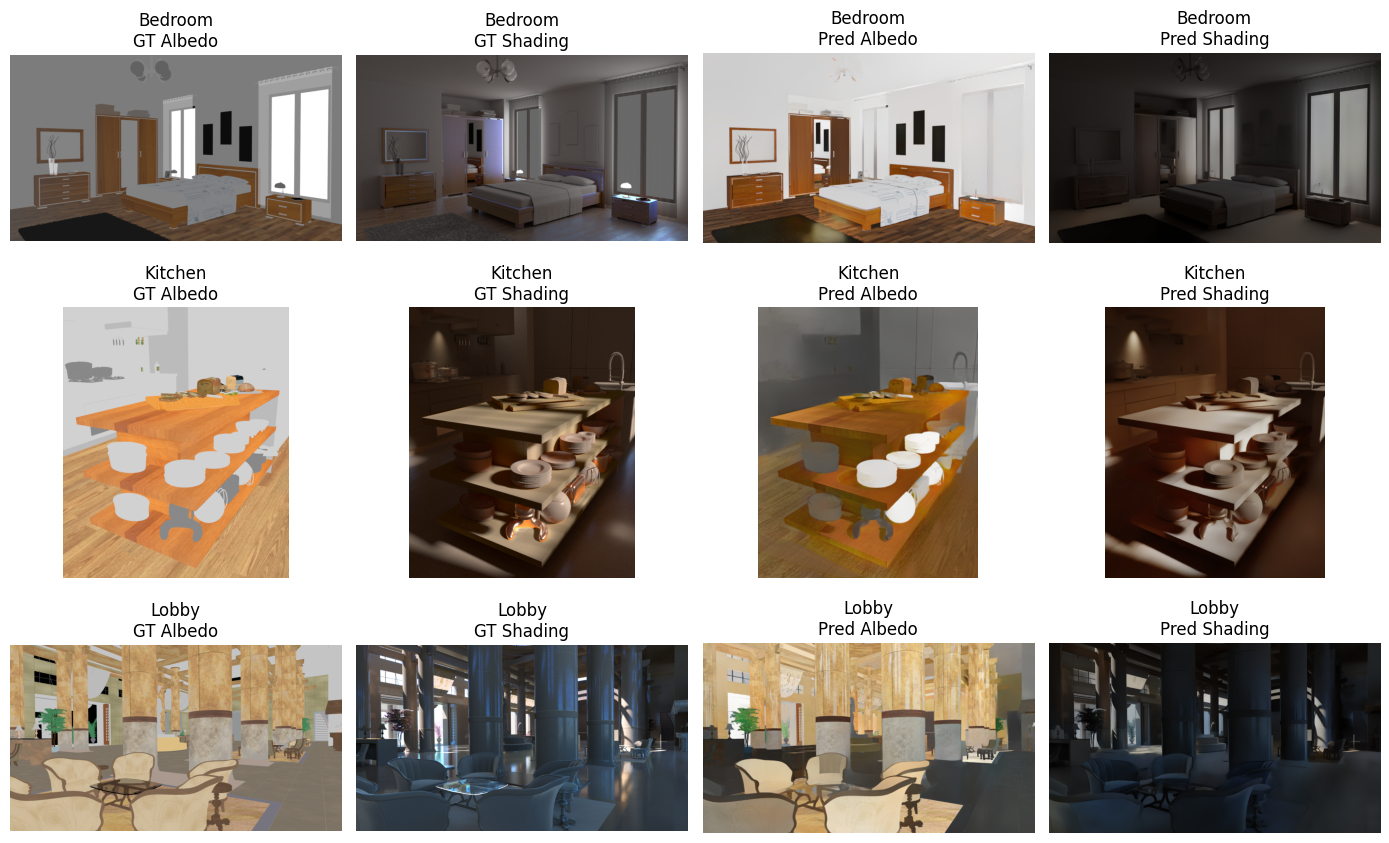

In [5]:
# Qualitative review: ARAP GT vs Predicted (3 samples)
import os, numpy as np, random
import matplotlib.pyplot as plt
from PIL import Image

# Resolve directories (fallback to defaults if not defined earlier)
pred_alb_dir = globals().get('arap_pred_albedo_dir', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Output_Images\albedo")
pred_shd_dir = globals().get('arap_pred_shading_dir', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Output_Images\shading")
gt_alb_dir = globals().get('arap_gt_albedo_dir', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo")
gt_shd_dir = globals().get('arap_gt_shading_dir', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading")

valid_exts = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']

def find_existing(base_dir, stem, suffix):
    """Find a file in base_dir matching stem + suffix + ext for common extensions."""
    for ext in valid_exts:
        p = os.path.join(base_dir, f"{stem}{suffix}{ext}")
        if os.path.exists(p):
            return p
    return None

def load_rgb(path):
    img = Image.open(path)
    # Drop alpha if exists and convert to RGB for visualization consistency
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return np.asarray(img)

# Collect candidate stems from predicted albedo
pred_alb_files = [f for f in os.listdir(pred_alb_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
pred_alb_files.sort()
stems = []
for f in pred_alb_files:
    low = f.lower()
    if low.endswith('_alb.png') or low.endswith('_alb.jpg') or low.endswith('_alb.jpeg'):
        stem = f.rsplit('_alb', 1)[0]
        # Ensure corresponding predicted shading and GT files exist
        pred_shd_path = find_existing(pred_shd_dir, stem, '_shd')
        gt_alb_path = find_existing(gt_alb_dir, stem, '_albedo')
        gt_shd_path = find_existing(gt_shd_dir, stem, '_shading')
        if pred_shd_path and gt_alb_path and gt_shd_path:
            stems.append(stem)

if not stems:
    raise RuntimeError("No matching ARAP samples found with both GT and predictions. Ensure outputs and GT folders are populated.")

# Take first 3 for reproducibility (or fewer if less available)
sample_stems = stems[:3]
print("Selected ARAP samples:", sample_stems)

# Plot: columns = [GT Albedo, GT Shading, Pred Albedo, Pred Shading]
cols = 4
rows = len(sample_stems)
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, stem in enumerate(sample_stems):
    gt_alb_path = find_existing(gt_alb_dir, stem, '_albedo')
    gt_shd_path = find_existing(gt_shd_dir, stem, '_shading')
    pred_alb_path = find_existing(pred_alb_dir, stem, '_alb')
    pred_shd_path = find_existing(pred_shd_dir, stem, '_shd')

    # Load images
    gt_alb = load_rgb(gt_alb_path) if gt_alb_path else None
    gt_shd = load_rgb(gt_shd_path) if gt_shd_path else None
    pr_alb = load_rgb(pred_alb_path) if pred_alb_path else None
    pr_shd = load_rgb(pred_shd_path) if pred_shd_path else None

    items = [("GT Albedo", gt_alb), ("GT Shading", gt_shd), ("Pred Albedo", pr_alb), ("Pred Shading", pr_shd)]
    for c, (title, img) in enumerate(items):
        ax = axes[r, c]
        ax.axis('off')
        ax.set_title(f"{stem}\n{title}")
        if img is None:
            ax.text(0.5, 0.5, 'Missing', ha='center', va='center')
        else:
            if img.ndim == 2:
                ax.imshow(img, cmap='gray', vmin=0, vmax=255)
            else:
                ax.imshow(img)

plt.tight_layout()
plt.show()

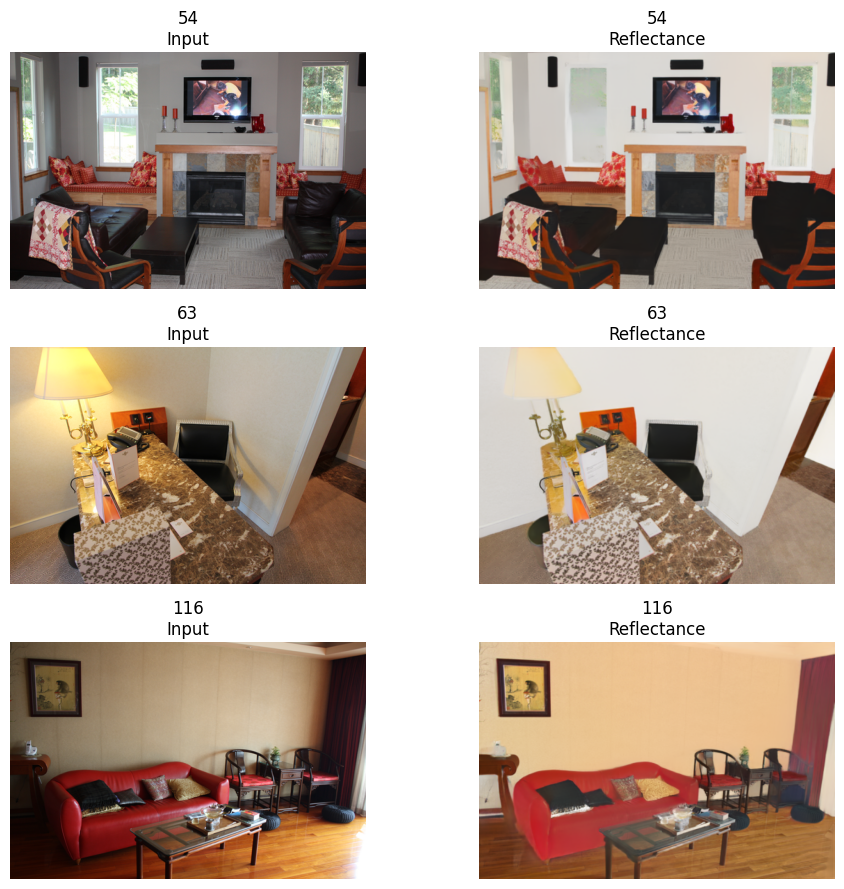

Displayed IIW samples: ['54', '63', '116']


In [6]:
# Qualitative review: IIW Input vs Reflectance (3 samples)
import os, re, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Resolve directories from globals or use defaults
iiw_input_dir = globals().get('iiw_input_dir', r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images")
iiW_output_dir_fallback = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\output"
iiw_output_dir = globals().get('iiw_output_dir', iiW_output_dir_fallback)

valid_exts = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']

def numeric_key(fname: str):
    stem = os.path.splitext(fname)[0]
    m = re.match(r'^(\d+)', stem)
    if m:
        return (int(m.group(1)), stem.lower())
    return (float('inf'), stem.lower())

def find_input_image(base_dir: str, stem: str):
    for ext in valid_exts:
        p = os.path.join(base_dir, f"{stem}{ext}")
        if os.path.exists(p):
            return p
    return None

# Collect reflectance outputs
if not os.path.isdir(iiw_output_dir):
    raise RuntimeError(f"IIW output directory not found: {iiw_output_dir}")
refl_files = [f for f in os.listdir(iiw_output_dir) if f.lower().endswith(('_reflectance.png','_reflectance.jpg','_reflectance.jpeg'))]
if not refl_files:
    raise RuntimeError("No IIW reflectance outputs found. Run the IIW processing cell first.")
refl_files.sort(key=numeric_key)

# Build up to 3 (input, reflectance) pairs
pairs = []
for f in refl_files:
    stem = os.path.splitext(f)[0]
    if not stem.endswith('_reflectance'):
        continue
    photo_id = stem.rsplit('_reflectance', 1)[0]
    inp_path = find_input_image(iiw_input_dir, photo_id)
    out_path = os.path.join(iiw_output_dir, f)
    if inp_path and os.path.exists(out_path):
        pairs.append((photo_id, inp_path, out_path))
    if len(pairs) >= 3:
        break

if not pairs:
    raise RuntimeError("Could not match any reflectance outputs to input images. Check file names and directories.")

# Plot: columns = [Input, Reflectance]
rows = len(pairs)
fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, (pid, inp, outp) in enumerate(pairs):
    inp_img = Image.open(inp).convert('RGB')
    refl_img = Image.open(outp).convert('RGB')  # qualitative display

    axes[r, 0].imshow(inp_img)
    axes[r, 0].set_title(f"{pid}\nInput")
    axes[r, 0].axis('off')

    axes[r, 1].imshow(refl_img)
    axes[r, 1].set_title(f"{pid}\nReflectance")
    axes[r, 1].axis('off')

plt.tight_layout()
plt.show()
print("Displayed IIW samples:", [pid for pid, _, _ in pairs])